In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
df = pd.read_pickle('test_gt.pkl')

In [15]:
df['standard_prediction_correct'] = df['truth'] == df['standard_prediction']
path_length_columns = df.filter(regex='path_length').columns

for path_length_column_name in path_length_columns:
    df[path_length_column_name] = df[path_length_column_name].fillna(df['standard_prediction'])
    df[path_length_column_name] = df[path_length_column_name].astype(int)
    correct_label = path_length_column_name.rstrip('_prediction') + '_correct'

    df[correct_label] = df[path_length_column_name] == df['truth']

In [16]:
corrects = df.filter(regex='correct').sum()
prop_corrects = (corrects/corrects.loc['standard_prediction_correct'])
prop_corrects = prop_corrects.filter(regex='path')
prop_corrects = prop_corrects.to_frame().reset_index()
prop_corrects['path_length'] = prop_corrects['index'].str.split('_').apply(lambda x: x[2]).astype(int)
prop_corrects = prop_corrects.drop(columns=['index'])
prop_corrects = prop_corrects.rename(columns={0: 'relative_accuracy'})

In [17]:
corrects

standard_prediction_correct    256
path_length_0_correct          256
path_length_1_correct          258
path_length_2_correct          261
path_length_3_correct          258
path_length_4_correct          257
path_length_5_correct          258
path_length_6_correct          258
path_length_7_correct          256
path_length_8_correct          257
path_length_9_correct          256
path_length_10_correct         257
path_length_11_correct         257
path_length_12_correct         256
path_length_13_correct         256
path_length_14_correct         256
path_length_15_correct         256
path_length_16_correct         256
path_length_17_correct         256
path_length_18_correct         256
path_length_19_correct         256
path_length_20_correct         255
dtype: int64

In [18]:
df.filter(regex='correct').count()

standard_prediction_correct    482
path_length_0_correct          482
path_length_1_correct          482
path_length_2_correct          482
path_length_3_correct          482
path_length_4_correct          482
path_length_5_correct          482
path_length_6_correct          482
path_length_7_correct          482
path_length_8_correct          482
path_length_9_correct          482
path_length_10_correct         482
path_length_11_correct         482
path_length_12_correct         482
path_length_13_correct         482
path_length_14_correct         482
path_length_15_correct         482
path_length_16_correct         482
path_length_17_correct         482
path_length_18_correct         482
path_length_19_correct         482
path_length_20_correct         482
dtype: int64

<Axes: xlabel='path_length'>

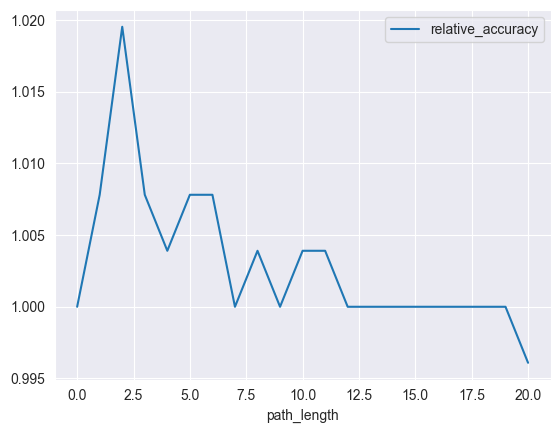

In [19]:
prop_corrects.plot('path_length',
              'relative_accuracy'
              )

In [21]:
# df[df.path_length_20_correct & ~df.standard_prediction_correct]